In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
from general_tools.notebook.tf import reset_tf_graph
from scipy.io import loadmat, savemat
from geo_tool import Point_Cloud
import os.path as osp
import matplotlib.pylab as plt
from scipy.spatial.distance import pdist
import numpy as np
import tensorflow as tf
import hdf5storage

In [3]:
from tflearn.layers.core import fully_connected
from tf_lab.point_clouds.encoders_decoders import encoder_with_convs_and_symmetry_new, decoder_with_fc_only
from tf_lab.data_sets.numpy_dataset import NumpyDataset
from tflearn.layers.conv import conv_2d
from sklearn.model_selection import train_test_split

In [4]:
# %matplotlib nbagg
%matplotlib inline

In [11]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/OUT/latent_diff_maps/experiments/human_poses/'

In [88]:
n_classes = 8
members_per_class = 150
n_pc_points = 15
val_per = 0.05
test_per = 0.15
train_per = 1.0 - (val_per + test_per)
seed = 42

In [89]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from geo_tool import Mesh
import inspect
from tf_lab.voxels.soup import plot_isosurface

def plot_mesh(in_mesh):
    faces = in_mesh.triangles
    verts = in_mesh.vertices
    verts = Point_Cloud(verts).center_in_unit_sphere().points
    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces])    
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)
    ax.set_xlabel("x-axis")
    ax.set_ylabel("y-axis")
    ax.set_zlabel("z-axis")
    
    miv = np.min(verts)
    mav = np.max(verts)
    ax.set_xlim(miv, mav)
    ax.set_ylim(miv, mav)
    ax.set_zlim(miv, mav)
    plt.tight_layout()
    plt.show()

In [90]:
in_shapes = osp.join(top_data_dir, '%d_shape_pc_points.mat' % (members_per_class, ))
in_shapes = loadmat(in_shapes)
in_shapes = in_shapes['selected_points']

In [91]:
# for i in range(1,5):
#     in_f = '/orions4-zfs/projects/optas/DATA/Meshes/SMPL_8_poses/Shape%s.off' % (i,)
#     in_m = Mesh(file_name=in_f)
#     plot_mesh(in_m)

In [92]:
n_shapes = n_classes * members_per_class
assert(n_shapes == len(in_shapes))

In [93]:
temp = np.zeros((n_shapes, n_pc_points, 3))
for i in xrange(len(in_shapes)):
#     pc = Point_Cloud(in_shapes[i]).center_in_unit_sphere()
    pc = Point_Cloud(in_shapes[i])
    pc, _ = pc.sample(n_pc_points)
    temp[i] = pc.points
in_shapes = temp

In [94]:
class_labels = np.zeros(n_shapes)
c = 0
for i in range(n_shapes):
    if i % members_per_class == 0:
        c += 1
    class_labels[i] = c
class_labels -= 1

In [95]:
all_ids = np.arange(n_shapes)
train_ids, rest_ids = train_test_split(all_ids, stratify=class_labels, train_size=train_per, random_state=seed)
test_ids, val_ids = train_test_split(rest_ids, stratify=class_labels[rest_ids], train_size=int(n_shapes*test_per), random_state=seed)
# np.sum(np.logical_and(test_ids>=300,  test_ids<400))
in_data = dict()
in_data['train'] = train_ids
in_data['test'] = test_ids
in_data['val'] = val_ids

In [96]:
for s in ['train', 'test', 'val']:
    idx = in_data[s].copy()
    in_data[s] = NumpyDataset([in_shapes[idx], class_labels[idx], idx], ['pc_points', 'labels', 'ids'])

['pc_points', 'labels', 'ids']
['pc_points', 'labels', 'ids']
['pc_points', 'labels', 'ids']


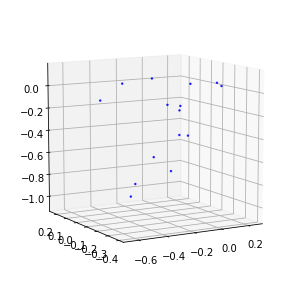

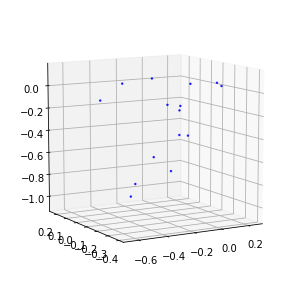

In [109]:
np.where(c2)

Point_Cloud(in_data['train'].pc_points[4]).plot(in_u_sphere=False)

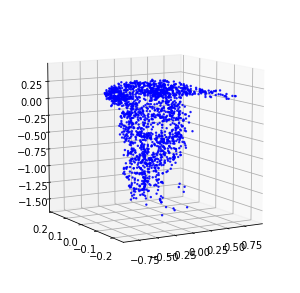

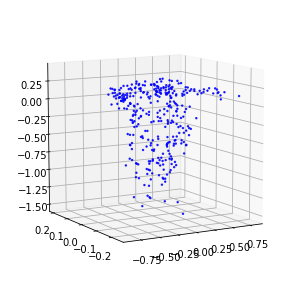

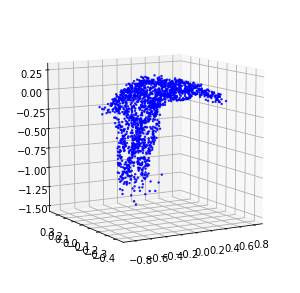

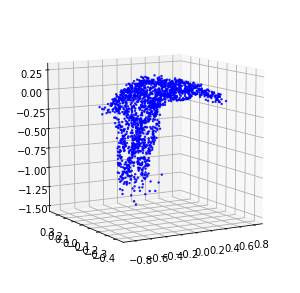

In [97]:
c1 = in_data['train'].labels == 1

Point_Cloud(in_data['train'].pc_points[c1].reshape(-1, 3)).plot(in_u_sphere=False)

c1 = in_data['test'].labels == 1
Point_Cloud(in_data['test'].pc_points[c1].reshape(-1, 3)).plot(in_u_sphere=False)

c2 = in_data['train'].labels == 2
Point_Cloud(in_data['train'].pc_points[c2].reshape(-1, 3)).plot(in_u_sphere=False)

In [98]:
assert(np.all(np.unique(np.hstack([test_ids, train_ids, val_ids])) == np.arange(n_shapes)))

In [99]:
reset_tf_graph()

In [100]:
with tf.variable_scope('pc_based_net') as scope:
    pc_pl = tf.placeholder(tf.float32, shape = (None, n_pc_points, 3) )
    labels_pl = tf.placeholder(tf.int64, shape=[None])                           
    layer = encoder_with_convs_and_symmetry_new(pc_pl, n_filters=[64, 128], b_norm=False)                                                     
    layer = fully_connected(layer, 64, activation='relu', weights_init='xavier')
    logits = fully_connected(layer, n_classes, activation='linear', weights_init='xavier')

In [101]:
prediction = tf.argmax(logits, axis=1)
target_ = labels_pl
correct_pred = tf.equal(prediction, target_)
avg_accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
one_hot_labels = tf.one_hot(labels_pl, depth=n_classes)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_labels)
loss = tf.reduce_mean(cross_entropy)

In [102]:
learning_rate = 0.001
opt = tf.train.AdamOptimizer(learning_rate)
opt_step = opt.minimize(loss)

In [103]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
init=tf.global_variables_initializer()
sess.run(init)

In [104]:
n_epochs = 30
batch_size = 25

train_losses = []
val_losses = []
test_losses = []

train_data = in_data['train']
val_data = in_data['val']
test_data = in_data['test']

batches_for_epoch = train_data.n_examples / batch_size

In [105]:
for epoch in range(n_epochs):    
    for _ in range(batches_for_epoch):        
        batch_d, batch_l, _ = train_data.next_batch(batch_size)
        feed_dict = {pc_pl:batch_d, labels_pl:batch_l}
        sess.run([opt_step, loss, avg_accuracy], feed_dict=feed_dict)

    feed_dict = {pc_pl:train_data.pc_points, labels_pl:train_data.labels}
    train_losses.append(sess.run([avg_accuracy], feed_dict=feed_dict))
    
    feed_dict = {pc_pl:val_data.pc_points, labels_pl:val_data.labels}
    val_losses.append(sess.run([avg_accuracy], feed_dict=feed_dict))
        
    feed_dict = {pc_pl:test_data.pc_points, labels_pl:test_data.labels}
    test_losses.append(sess.run([avg_accuracy], feed_dict=feed_dict))

    print epoch, train_losses[-1], val_losses[-1], test_losses[-1]

0 [0.75208342] [0.6833334] [0.72777784]
1 [0.92604172] [0.9000001] [0.93333334]
2 [0.92604172] [0.9000001] [0.91666669]
3 [0.94583333] [0.95000005] [0.95555562]
4 [0.96145838] [0.9666667] [0.97222227]
5 [0.96666664] [0.9666667] [0.9666667]
6 [0.96249998] [0.95000005] [0.96111119]
7 [0.96354163] [0.9666667] [0.97222227]
8 [0.96562499] [0.9666667] [0.98333335]
9 [0.96666658] [0.95000005] [0.96666676]
10 [0.9666667] [0.9666667] [0.98333335]
11 [0.97291672] [0.95000005] [0.9666667]
12 [0.96770835] [0.95000005] [0.97222233]
13 [0.97500002] [0.9666667] [0.98333335]
14 [0.96875] [0.95000005] [0.9666667]
15 [0.97708338] [0.95000005] [0.97777784]
16 [0.97499996] [0.9666667] [0.98333335]
17 [0.97916669] [0.9666667] [0.97777778]
18 [0.97291672] [0.95000005] [0.9666667]
19 [0.97604167] [0.9666667] [0.97777784]
20 [0.9802084] [0.95000005] [0.97222221]
21 [0.98333341] [0.9666667] [0.97777784]
22 [0.98125005] [0.9666667] [0.97777784]
23 [0.9822917] [0.95000005] [0.97222233]
24 [0.98020828] [0.9666667

In [67]:
feed_dict = {pc_pl:test_data.pc_points, labels_pl:test_data.labels}
print (sess.run([avg_accuracy], feed_dict=feed_dict))

[0.91111112]


TypeError: 'NumpyDataset' object does not support indexing

In [30]:
from general_tools.simpletons import are_disjoint_sets
are_disjoint_sets([set(in_data['test'].ids), set(in_data['train'].ids), set(in_data['val'].ids)])

True

In [23]:
in_shapes = osp.join(top_data_dir, '150_shape_pc_points.mat')
in_shapes = loadmat(in_shapes)
in_shapes = in_shapes['selected_points'].astype(np.float32)

In [186]:
# feed_dict = {diffs_pl:test_data.diff_maps, labels_pl:test_data.labels}
# pred = sess.run(prediction, feed_dict=feed_dict)
# missed = np.where(test_data.labels != pred)
# pred[missed]
# test_data.labels[missed]
# test_data.ids[missed]